In [19]:
#install.packages('randomForest')
library(readxl)
library(randomForest)
library(readxl)
library(tidyverse)
#install.packages('dplyr')
library(dplyr)
library(Rcpp)


library(rpart)# Popular decision tree algorithm
#install.packages('rattle')
library(rattle)# Fancy tree plot
library(rpart.plot)# Enhanced tree plots
library(RColorBrewer)# Color selection for fancy tree plot
library(party) # Alternative decision tree algorithm
#install.packages('partykit')
library(partykit)# Convert rpart object to BinaryTree

#install.packages('tree')
library(tree)
#install.packages('multcomp')
library(multcomp)
#install.packages('party')


#install.packages('Metrics')
library(Metrics)
#install.packages('reprtree')
#devtools::install_github("MI2DataLab/randomForestExplainer")
#install.packages('randomForestExplainer')
library(randomForestExplainer)
#install.packages("scales")
library(scales)
#update.packages()
#install.packages("packagename")
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#install.packages("stats4")
#install.packages("splines")
library(stats4) #Load package stats
library(splines) #Load package splines
#To load package VGAM, need to load package stats4 and splines.
#install.packages("VGAM")
library(VGAM) #Load package VGAM


install.packages("psych")
install.packages("PerformanceAnalytics")
library(corrplot)
library(PerformanceAnalytics)
library(psych)






Warning message:
"package 'psych' is in use and will not be installed"
Warning message:
"package 'PerformanceAnalytics' is in use and will not be installed"
corrplot 0.84 loaded



# FA (weighted) Classifcation

,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,1,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,2,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,1,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,3,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,3,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,2,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


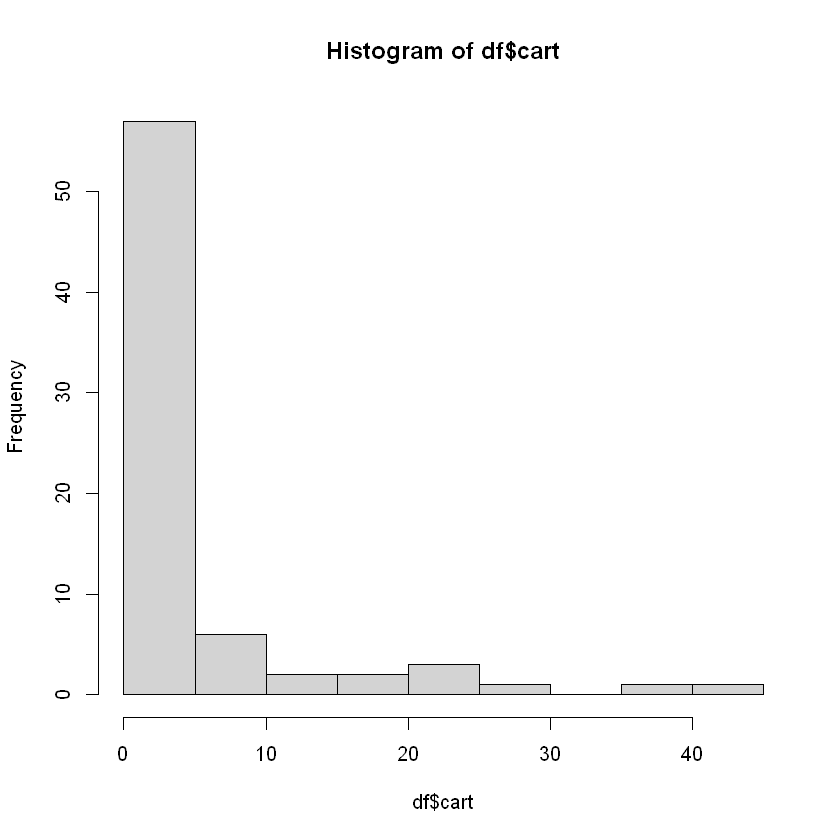

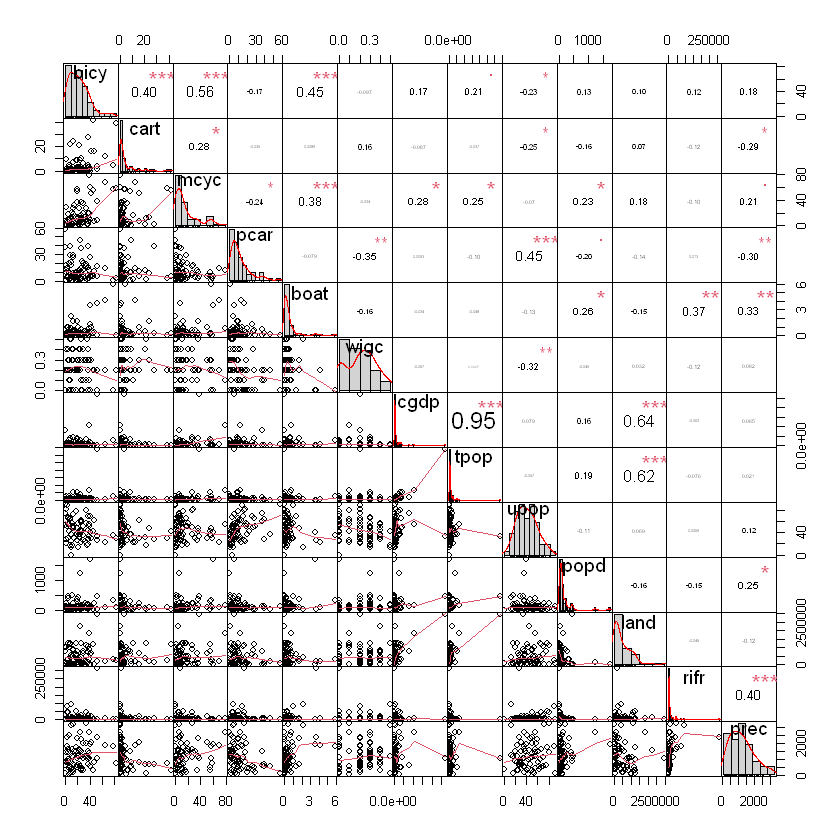

In [23]:
df.wa = read_excel( "../../results/df-water-access.xlsx" ,sheet=1)
df.exp =read_excel("../../results/df-water-explore.xlsx" ,sheet=1)
df.cluster = read_excel("../../results/df-fa-seven-cluster-rank.xlsx" ,sheet=1)
df.wb = read_excel("../../results/df-wb.xlsx" ,sheet=1 )
df.exp$clusters <- as.factor(df.cluster$clusters)
df <- merge(x = df.exp,
              y = df.wb,
              by = c("Country"))

df <- df[, c(1:13, 17,21)]
# ReScaling in 0 to 1 for all the necessary data
#df.scale = as.data.frame(apply(as.matrix(df[, c(2:7, 9:15)]), 2, rescale))
#df <- cbind(df,df.scale)
#df <- df[,c(1,8,16:28)]

head(df)

df.a <- df[, c(1:6,8)]
hist(df$cart)

explnatory <- df[,c(2:7, 9:15)]
chart.Correlation(explnatory, histogram=TRUE, pch=19 , tl.cex = .7 )

# Tree

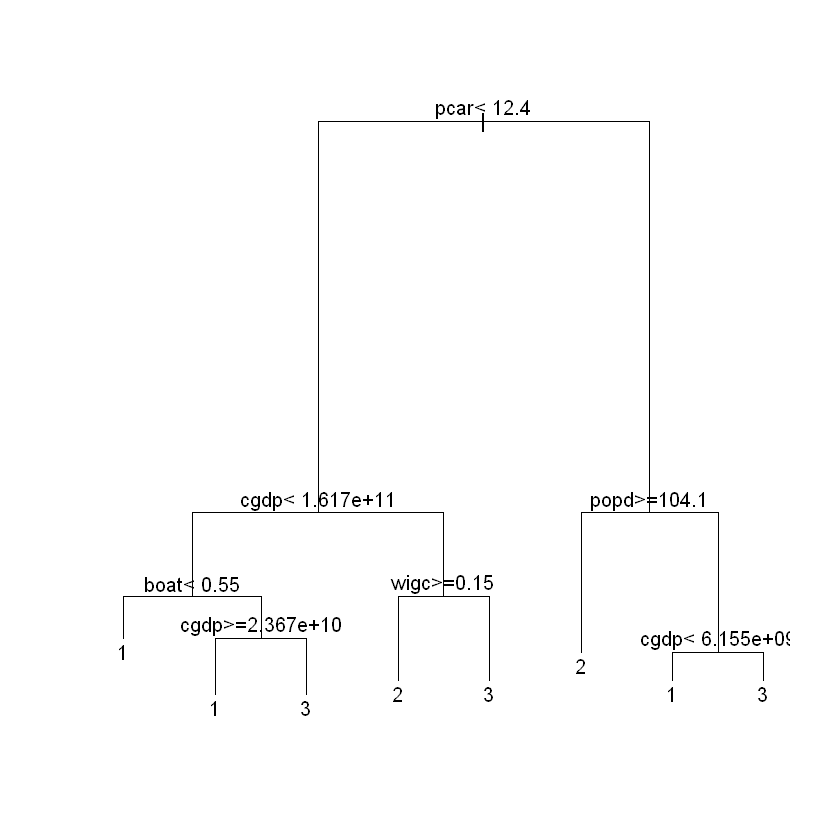


Classification tree:
rpart(formula = form, data = df, control = rpart.control(minsplit = 7, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0))

Variables actually used in tree construction:
[1] boat cgdp pcar popd wigc

Root node error: 36/73 = 0.49315

n= 73 

        CP nsplit rel error  xerror    xstd
1 0.388889      0   1.00000 1.00000 0.11866
2 0.138889      1   0.61111 0.80556 0.11613
3 0.083333      2   0.47222 0.75000 0.11458
4 0.027778      4   0.30556 0.63889 0.11025
5 0.010000      7   0.22222 0.72222 0.11365


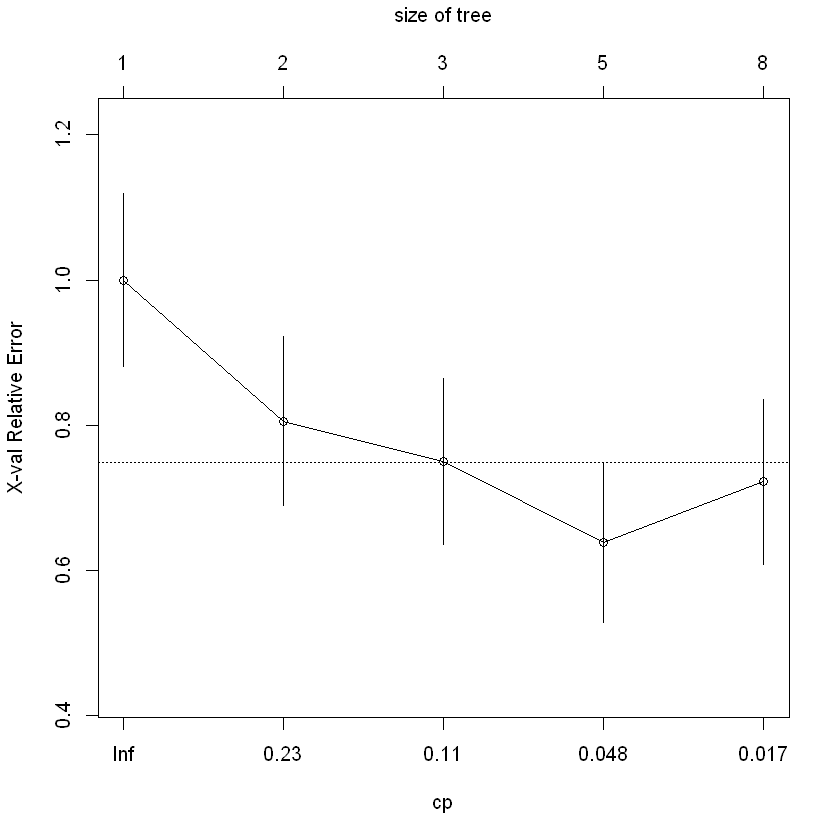

In [37]:
# Make big tree
form <- as.formula(clusters ~ . - Country)
tree.fwa <- rpart(form,data=df,control=rpart.control(minsplit=7,cp=0.01, xval = nrow(df), maxsurrogate = 0
))
            
# 
plot(tree.fwa)# Will make a mess of the plot

text(tree.fwa)
plotcp(tree.fwa)
printcp(tree.fwa)

#summary(tree.fwa) 

#prp(tree.fwa)# Will plot the tree
#prp(tree.fwa,varlen=4)# Shorten variable names





Call:
rpart(formula = form, data = df, control = rpart.control(minsplit = 7, 
    cp = 0))
  n= 73 

          CP nsplit rel error    xerror      xstd
1 0.38888889      0 1.0000000 1.0000000 0.1186556
2 0.13888889      1 0.6111111 0.6944444 0.1126229
3 0.08333333      2 0.4722222 0.6388889 0.1102516
4 0.04800000      4 0.3055556 0.6111111 0.1089012

Variable importance
pcar cgdp tpop popd wigc bicy upop land prec mcyc cart 
  22   17   15   14    8    7    5    4    3    3    2 

Node number 1: 73 observations,    complexity param=0.3888889
  predicted class=1  expected loss=0.4931507  P(node) =1
    class counts:    37    14    22
   probabilities: 0.507 0.192 0.301 
  left son=2 (49 obs) right son=3 (24 obs)
  Primary splits:
      pcar < 12.4         to the left,  improve=12.198510, (0 missing)
      wigc < 0.25         to the right, improve= 6.923826, (0 missing)
      cgdp < 109724700000 to the left,  improve= 4.938771, (0 missing)
      popd < 104.1462     to the right, improve= 

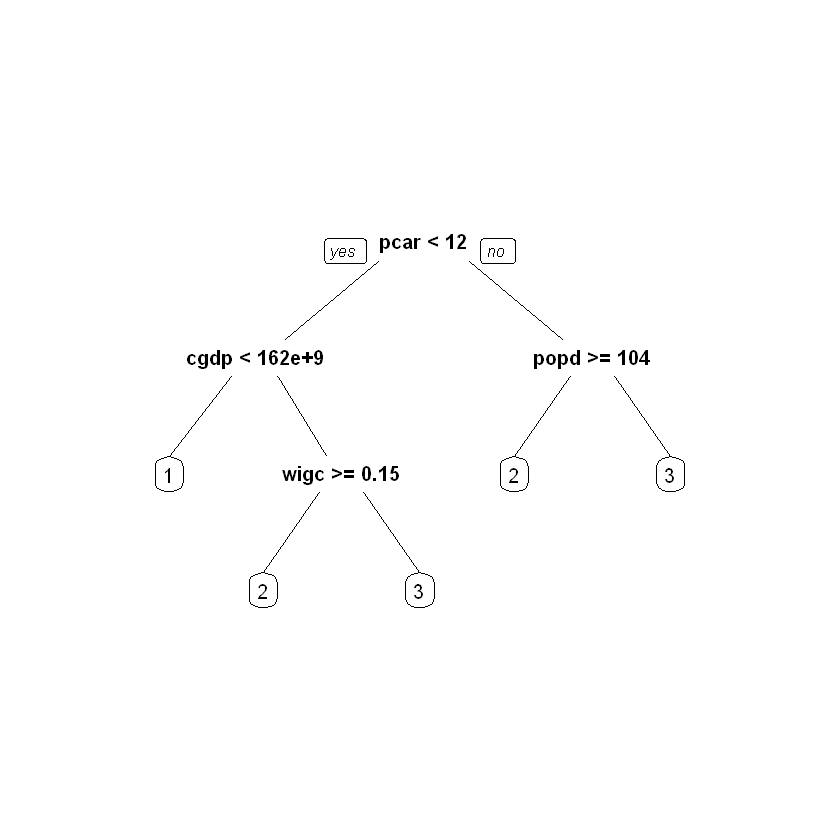

In [32]:
#Interatively prune the tree
tree.pru <- prune(tree.fwa, cp=0.048) # interactively trim the tree
prp(tree.pru) # display the new tree
summary(tree.pru)


Classification tree:
tree(formula = clusters ~ . - Country, data = df)
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "bicy" "popd" "prec"
Number of terminal nodes:  8 
Residual mean deviance:  0.8264 = 53.72 / 65 
Misclassification error rate: 0.1644 = 12 / 73 

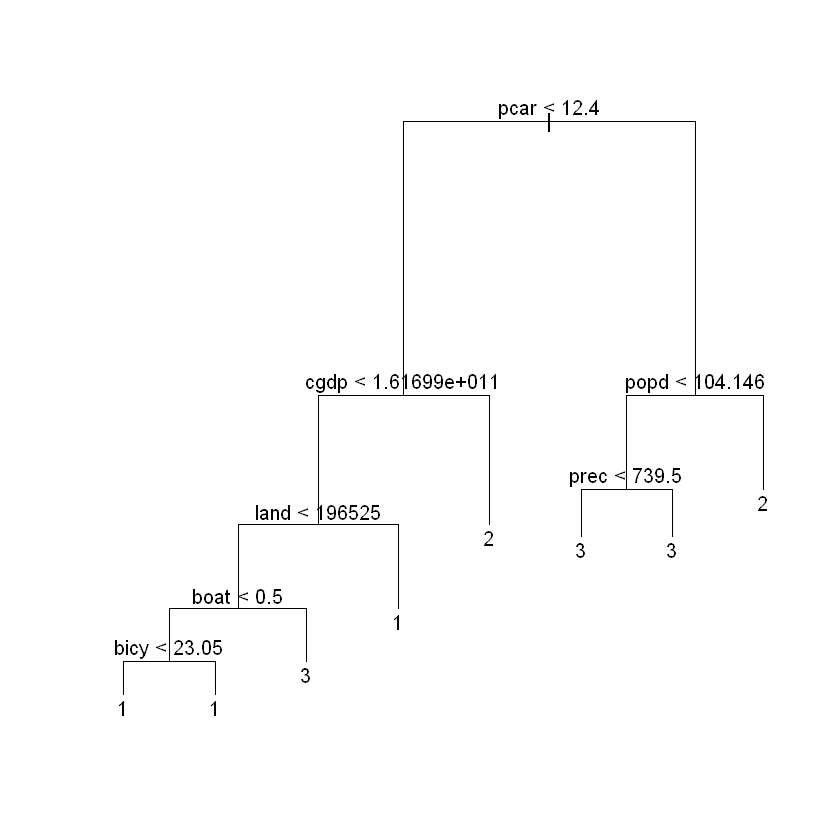

In [4]:
tree.wa = tree(clusters ~ . - Country  , data = df)
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0) #population density High density for six cluster group.

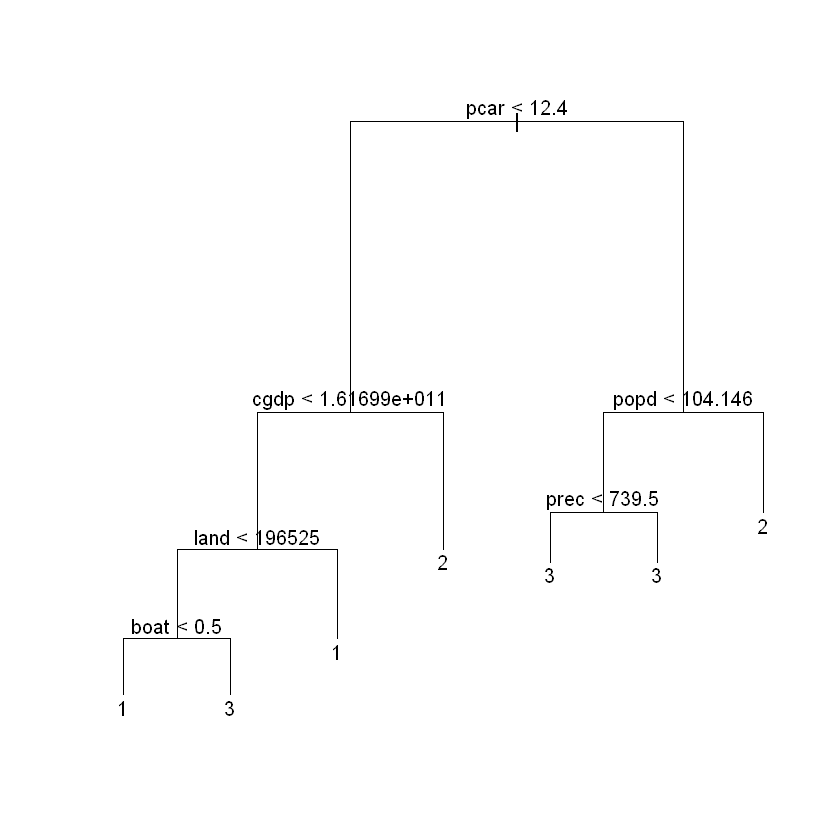

In [42]:
pru.wa <- prune.tree(tree.wa, best = 7 )
plot(pru.wa)
text(pru.wa, pretty = 0)

# Random Forest


Call:
 randomForest(formula = clusters ~ . - Country, data = df, ntree = 200,      mtry = 13) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 13

        OOB estimate of  error rate: 34.25%
Confusion matrix:
   1 2  3 class.error
1 32 1  4   0.1351351
2  3 4  7   0.7142857
3  6 4 12   0.4545455


                Length Class  Mode     
call              5    -none- call     
type              1    -none- character
predicted        73    factor numeric  
err.rate        800    -none- numeric  
confusion        12    -none- numeric  
votes           219    matrix numeric  
oob.times        73    -none- numeric  
classes           3    -none- character
importance       13    -none- numeric  
importanceSD      0    -none- NULL     
localImportance   0    -none- NULL     
proximity         0    -none- NULL     
ntree             1    -none- numeric  
mtry              1    -none- numeric  
forest           14    -none- list     
y                73    factor numeric  
test              0    -none- NULL     
inbag             0    -none- NULL     
terms             3    terms  call     

,MeanDecreaseGini
bicy,1.692158
cart,1.068966
mcyc,1.768280
pcar,15.342014
boat,1.747296
wigc,1.563550
cgdp,3.884109
tpop,1.950774
upop,2.133755
popd,7.718696


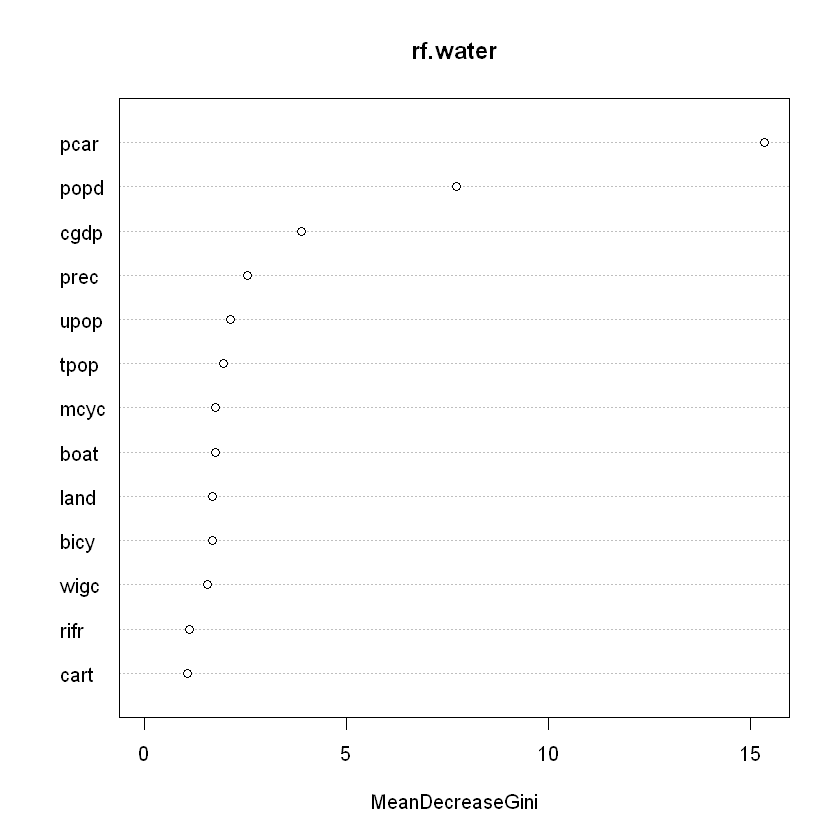

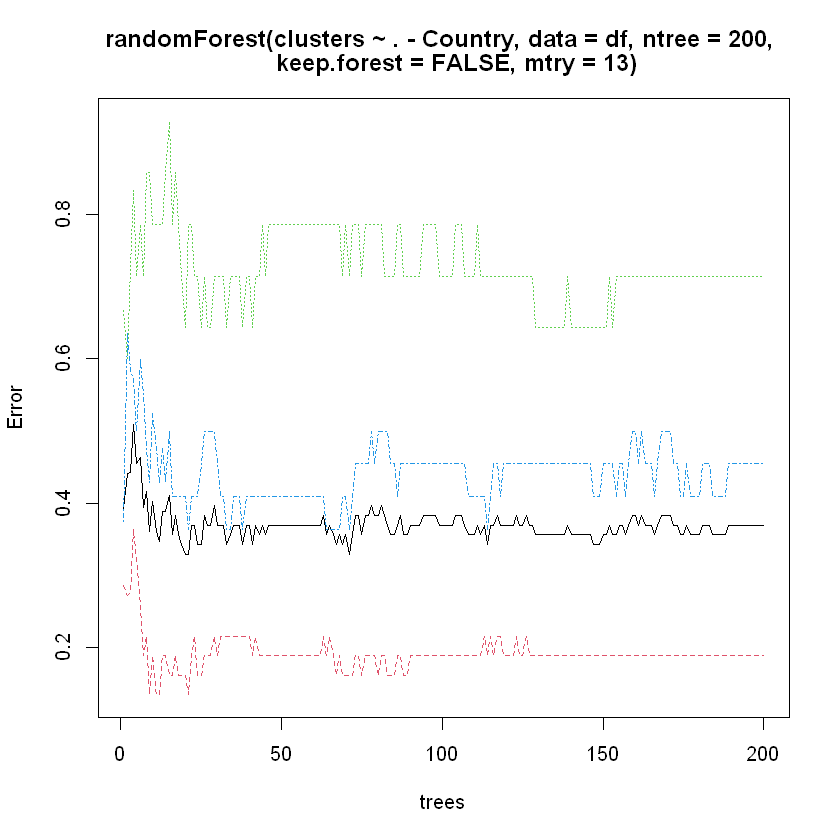

In [101]:
rf.water = randomForest(clusters~. -Country, data = df , ntree= 200,mtry=13)
print(rf.water)

summary(rf.water)

importance <- importance(rf.water, sort = TRUE)
importance

# create an importance plot
varImpPlot(rf.water, sort=TRUE, n.var=min(30, nrow(rf.water$importance)),
           type=NULL, class=NULL, scale=TRUE )
#plot
plot(randomForest(clusters~. -Country, data = df ,ntree=200,  keep.forest=FALSE, mtry=13) )

The MeanDecreaseGini measures the Gini importance = how important the features are over all splits done in the tree/forest - whereas for each individual split the Gini importance indicates how much the Gini criterion = "unequality/heterogeneity" was reduced using this split.
mori, upop, pcar popd, mcyc important and contributed most to obtaining such splits, so they are considered more important.

# MULTINOMIAL LOGISTIC REGRESSION

In [102]:
head(df)
with(df, table( df[,8]), )


,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,1,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,2,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,1,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,3,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,3,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,2,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666



 1  2  3 
37 14 22 

In [103]:
head(df)

# Fit the model
model <- nnet::multinom(clusters ~. -Country  , data = df)
# Summarize the model
summary(model)

#z values
z <- summary(model)$coefficients/summary(model)$standard.errors
z
# 2-tailed z test
p <- (1 - pnorm(abs(z), 0, 1)) * 2
p

## extract the coefficients from the model and exponentiate
exp(coef(model))

# Make predictions
predicted.classes <- model %>% predict(df)
head(predicted.classes)

head(pp <- fitted(model))
# Model accuracy
mean(predicted.classes == df$clusters)

fit.MLR <- vglm( clusters ~ bicy + cart + mcyc +
                pcar+boat+wigc+cgdp+tpop+upop+popd+land+rifr+prec ,
                family=multinomial, df)
summary(fit.MLR)




,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,1,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,2,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,1,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,3,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,3,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,2,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# weights:  45 (28 variable)
initial  value 80.198697 
iter  10 value 58.061005
iter  20 value 50.152344
iter  30 value 47.266801
iter  40 value 36.751882
iter  50 value 14.121753
iter  60 value 10.313087
iter  70 value 9.665696
iter  80 value 9.404948
iter  90 value 9.383250
iter 100 value 9.377675
final  value 9.377675 
stopped after 100 iterations


Call:
nnet::multinom(formula = clusters ~ . - Country, data = df)

Coefficients:
  (Intercept)        bicy       cart      mcyc     pcar       boat       wigc
2   -65.87625  0.74372506 -1.6491019 0.8508328 2.011537 -20.004327   2.095217
3    -5.50672 -0.05525467  0.0101058 0.1370160 0.393473   3.561614 -17.074510
          cgdp          tpop        upop        popd          land         rifr
2 1.829884e-10  5.021029e-07 -0.28518550 0.043695759 -1.730291e-04 0.0005869496
3 7.084605e-11 -1.439000e-07  0.06959758 0.003163357 -3.080163e-06 0.0001031240
          prec
2  0.014501776
3 -0.002122235

Std. Errors:
   (Intercept)         bicy         cart         mcyc         pcar         boat
2 1.143801e-22 1.498158e-21 2.239588e-22 1.855283e-21 2.732538e-21 3.115736e-23
3 3.227843e-23 5.011871e-22 2.215412e-22 7.218089e-22 1.760728e-21 2.258123e-23
          wigc         cgdp         tpop         upop         popd         land
2 2.330818e-23 2.842053e-11 1.138901e-14 6.554658e-21 1.937502e-20

,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
2,-5.759416e+23,4.964263e+20,-7.363418e+21,4.585999e+20,7.361423e+20,-6.420419e+23,8.989194e+22,6.43860,44086627,-4.350883e+19,2.255262e+18,-2.982630e+12,2.439702e+15,1.457456e+17
3,-1.706006e+23,-1.102476e+20,4.561587e+19,1.898230e+20,2.234718e+20,1.577245e+23,-1.801811e+24,11.67388,-40465524,3.426130e+19,9.673772e+17,-7.632147e+10,4.140059e+14,-7.042485e+16


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
2,0,0,0,0,0,0,0,1.205804e-10,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0.000000e+00,0,0,0,0,0,0


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
2,2.456451e-29,2.1037576,0.1922225,2.341596,7.474795,2.052255e-09,8.127205e+00,1,1.0000005,0.7518748,1.044664,0.9998270,1.000587,1.014607
3,4.059399e-03,0.9462441,1.0101570,1.146846,1.482119,3.521999e+01,3.842685e-08,1,0.9999999,1.0720767,1.003168,0.9999969,1.000103,0.997880


[1] 1 2 1 3 3 2
Levels: 1 2 3

,1,2,3
1,9.822329e-01,1.390109e-39,1.776707e-02
2,2.959525e-14,1.000000e+00,9.185569e-09
3,6.909582e-01,5.649387e-95,3.090418e-01
4,2.301398e-06,6.622490e-03,9.933752e-01
5,4.420177e-04,2.344073e-17,9.995580e-01
6,1.095237e-66,1.000000e+00,7.845618e-73


[1] 0.9452055

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working w

Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta 

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):


Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):


Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(e


Call:
vglm(formula = clusters ~ bicy + cart + mcyc + pcar + boat + 
    wigc + cgdp + tpop + upop + popd + land + rifr + prec, family = multinomial, 
    data = df)

Coefficients: 
                Estimate Std. Error z value Pr(>|z|)  
(Intercept):1  2.116e+00  2.135e+00   0.991   0.3215  
(Intercept):2 -8.524e+00  4.954e+00      NA       NA  
bicy:1        -4.629e-03  4.648e-02  -0.100   0.9207  
bicy:2         1.145e-01  8.862e-02   1.292   0.1965  
cart:1         5.103e-03  8.117e-02   0.063   0.9499  
cart:2        -2.589e-01  2.009e-01      NA       NA  
mcyc:1        -1.030e-02  4.744e-02  -0.217   0.8281  
mcyc:2         8.432e-02  6.420e-02   1.313   0.1891  
pcar:1        -2.261e-01  9.518e-02      NA       NA  
pcar:2         1.372e-01  7.788e-02   1.761   0.0782 .
boat:1        -1.758e+00  1.309e+00  -1.343   0.1793  
boat:2        -2.559e+00  1.561e+00      NA       NA  
wigc:1         8.587e+00  4.585e+00   1.873   0.0611 .
wigc:2         1.096e+01  7.047e+00   1.556   0.